<p> manually set node 6-9 as full opening </p>
<p> change dt from 0.015s to 0.01s (less than 0.015s, 0.012s also works,try now), which always works</p>
<p> Courant Number = 0.54 for dt=0.012s, =0.675 for dt=0.015s, more than 0.675 does not work</p>
<p> Increase inflow means decreasing dt </p>
<p> Assumption: pipes are equally divided according to grid number (satisfied)</p>
<p> ** 1680s filling, 720s drying, dyring process is very fast,nearly 20s** </p>

In [1]:
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time
#from __future__ import division 

Populating the interactive namespace from numpy and matplotlib


In [2]:
fi = "../indata/Model2/Model2_Epipe_new.inp"    
fc = "../indata/Model2/Model2_Epipe_new_include_drying.config" 
mtype=1
n1=PyNetwork(fi,fc,mtype)

In [4]:
v = 1
Q_in1 = list(n1.Ds[0]**2*pi/4*v*np.ones(int(n1.M*0.7)))
Q_in2 = list(np.zeros(int(n1.M*0.3)+1))
Q_in = Q_in1+Q_in2
jt = n1.nodeTypes
dt = n1.T/n1.M  
print dt
aa=arange(0,len(jt)) 
for j in range(len(aa[n1.nodeTypes==1])):#find the junction1s and set boundary value time series to .1*(pipe diameter)
    bvt = n1.Ds[5]*np.ones(n1.M+1)
    n1.setbVal(j,bvt)
#specify an boundary inflow at node 0   
n1.setbVal(0,Q_in)
n1.setbVal(1,n1.Ds[4]*np.ones(n1.M+1))
Np = n1.Nedges # number of pipes
p1 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], n1.M, n1.a[0])      
h0 = p1.AofH(10,False)
A00 = h0*np.ones(n1.Ns[0])  
Q00 = Q_in[0]*np.ones(n1.Ns[0])
h1 = p1.AofH(0.005,False)
n1.setIC(0,A00,Q00) 
for k in range(2,Np):                     #pipe number starts from 0, ends at Np-1. Here from 2 to Np-1
    A00 = h1*np.ones(n1.Ns[k])  #set other pipes to 1e-3*(pipe diameter) to avoid near-zero roundoff issues
    Q00 = np.zeros(n1.Ns[k])
    n1.setIC(k, A00, Q00)     

0.012


In [5]:
V0 = n1.getTotalVolume()                 
n1.runForwardProblem(dt) 
V1= n1.getTotalVolume()
print "The total run time is %f s, the total volume change is %f %f cubic meters" %(n1.solve_time, V1,V0)

The total run time is 417.857437 s, the total volume change is 12.263248 7.354231 cubic meters


# 1.1 Pressure Head of Pipe_interest Changes With Time, Dynamic Picture
# (Simultaneous and Overlap)
## Note: can also get pressure along pipe at a certain time

<IPython.core.display.Javascript object>


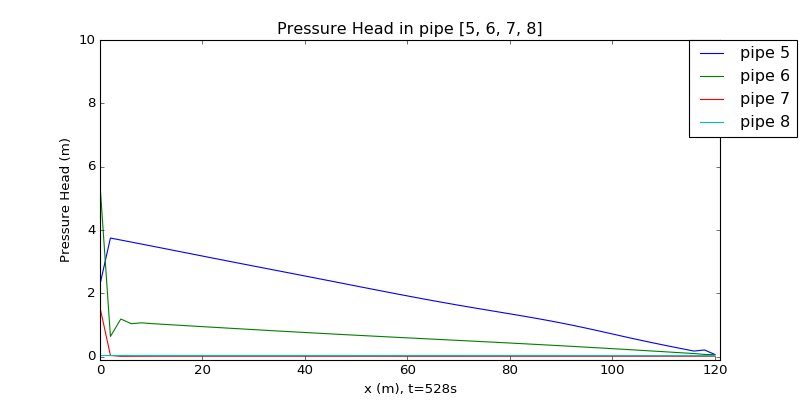

In [7]:
#*********************************************************************************
pipe_interest=[5,6,7,8]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=1800               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 10)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/EpipeFig/pipe %s overlap %d-%d s.mp4'%((str(pipe_interest)),t_start,t_end))

#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')

In [ ]:
#*********************************************************************************
pipe_interest=[5,6,7,8]
t_delta=1              # unit: s
t_start=1680               # unit:s
t_end=2400               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1,0.15 )
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/EpipeFig/pipe %s overlap %d-%d s.mp4'%((str(pipe_interest)),t_start,t_end))

# 1.2  Pressure Head of Pipe_interest Changes With Time, Dynamic Picture
# (Countinuous)
## Note: can also get pressure along pipe at a certain time

<IPython.core.display.Javascript object>


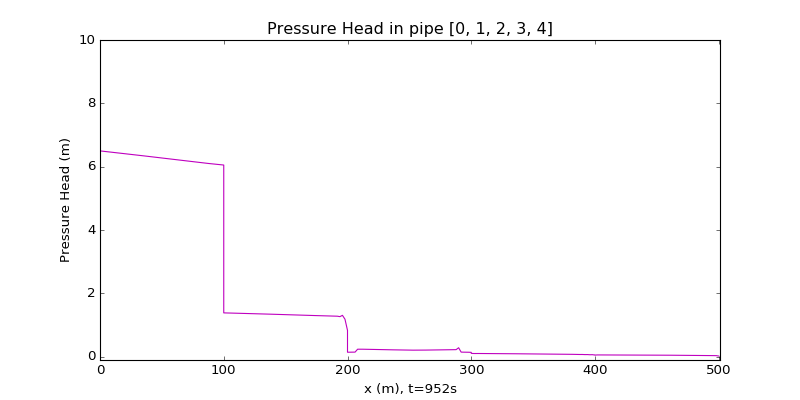

In [14]:
#*********************************************************************************
pipe_interest=[0,1,2,3,4]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=1800               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 10)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/EpipeFig/pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))

#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')

In [ ]:
#*********************************************************************************
pipe_interest=[5,6,7,8]
t_delta=1              # unit: s
t_start=1680               # unit:s
t_end=2400               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 0.3)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=100, blit=True)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/EpipeFig/pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))

# 2.1 Cross Sectional Area of Pipe_interest  (same as pipe above)


In [10]:
# Print the cross sectional area of pipe_interest (the same pipe above)

#pipe_interest=range(0,9)
A_pipe=[]
for i in range(len(pipe_interest)):
    pipe_number=pipe_interest[i]
    A_pipe.append(n1.Ds[pipe_number]**2/4*pi)
    print 'pipe %d cross sectional area: A=%.4f m^2'%(pipe_number,A_pipe[i])


pipe 0 cross sectional area: A=0.0707 m^2
pipe 1 cross sectional area: A=0.0707 m^2
pipe 2 cross sectional area: A=0.0707 m^2
pipe 3 cross sectional area: A=0.0707 m^2
pipe 4 cross sectional area: A=0.0707 m^2


# 2.2  The Veolcity (Q/A) in Pipe_interest Changes with Time, Dynamic Picture 
# (same pipe above)

In [13]:
# the veolcity in pipe_interest changes with time ,dynamic picture (same pipe above)
import pylab as pl
from IPython import display


U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

Mi_draw = 300
for m in range(0,M_total,Mi_draw) :
    U_interest_tfixed=[] 
    for i in range(len(pipe_interest)):
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Utemp=[]
        for k in range(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]
            AN=qh[idx_t(0,N,m,N)]
            Qk=qh[idx_t(1,k,m,N)]
            # when Q is actually very samll and its value is due to numerical oscillation, set it as 0
            if abs(Ak-AN)<0.1*A_pipe[i] and AN<0.1*A_pipe[i]:  
                Qk=0   
            vk = Qk/Ak                 
            Utemp.append(vk)
            #Utemp=[qh[idx_t(1,k,m,N)]/qh[idx_t(0,k,m,N)] for k in range(1,N+1)]
        U_interest_tfixed.append(Utemp)
    U_interest.append(U_interest_tfixed)
    U_interest_combine = np.concatenate(U_interest[int(m/Mi_draw)],axis =0)
    # plt.figure(figsize= (15,5))    #plot on different figures
    figsize= (15,5)                 #plot on the same figure
    pl.clf()
    pl.plot(x_interest_combine,U_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    '''
    #plt.figure(figsize= (15,5))
    for i in range(len(pipe_interest)):
        figsize(15,5)
        plot(x_interest[i],U_interest[int(m/Mi_draw)][i], lw = 1,  label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
        # m is time step, and should divide m/Mi_draw to get what we need
        #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    '''
    xlabel('x (m)')        
    ylabel('Velocity (m/s)')
    xlim(0,x_interest[-1][-1]+1)
    Umax=1.1*max(U_interest_combine)
    #ylim(-0.1,2.5)
    ylim(-0.5,1.2*Umax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Velocity along pipe %s'%str(pipe_interest))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    #time.sleep(0.01)
    # print U_interest[5][1]   # first index is #*Mi timestep, second index is pipe # in pipe_interest list



KeyboardInterrupt: 

# 3.1 Decide Time Reaching Steady State
##       Based on standard deviation of pressure gradient along pipes

In [15]:
#****************************************************************************
t_interval = 1                  # unit: s
pipe_interest = range(0,9)      # Pipes you want to know 
#****************************************************************************

def get_gradient(distance,pressure_series):
    gradient = []
    for k in xrange(len(pressure_series)-1):
        gradi = (pressure_series[k]-pressure_series[k+1])/distance
        #if gradi == 0:                     # 0 is a const to reflect initial gradient
            #return 0
        gradient.append(gradi)
    return gradient

Mi_draw = int(t_interval/dt)
average_all=[]
deviation_all=[]
for i in xrange(len(pipe_interest)):
    pipe_number = pipe_interest[i]
    dx = n1.Ls[pipe_number]/n1.Ns[pipe_number]
    t_dev=[]
    deviation = []
    average = []  
    for m in range(0,n1.M+1,Mi_draw):
        Hx = n1.pressureSpaceSeries(pipe_number,m)
        gradient = get_gradient(dx,Hx[2:-2])           # eliminate first two grids and the last grid
        ave = np.mean(gradient)
        gradient = [gradient[loc] / ave for loc in range(len(gradient))]  # normalize gradient
        deviation.append(np.std(gradient))
        average.append(ave)
        t_dev.append(m*dt)
    average_all.append(average)
    deviation_all.append(deviation)
    
'''    
    plt.figure(figsize= (10,4)) 
    plt.subplot(1,2,1)
    plot(t_dev,deviation) 
    plt.ylim(-0.1,200)
    plt.xlabel('t(s)')
    plt.ylabel('pressure gradient deviation')
    plt.title('Pipe %d Pressure Gradient Standard Deviation'%pipe_number)
    
    plt.subplot(1,2,2)
    plot(t_dev,average)
    xlabel('t(s)')
    ylabel('pressure gradient')
    title('Pipe %d Pressure Gradient Average'%pipe_number)
    #savefig('/home/xin/pipes/examples/output_data/EpipeFig/All_Std+Ave/pipe %d_Std_Ave.png'%pipe_number, bbox_inches='tight')
    
    
    # Only plot std below
    
    plt.figure(figsize= (3,1.5)) 
    plt.ylim(-0.1,200)
    plot(t_dev,deviation) 
    plt.xlabel('t(s)')
    plt.ylabel('deviation')
    plt.title('Pipe %d std ~ t'%pipe_number)
    #savefig('/home/xin/pipes/examples/output_data/EpipeFig/All_Std/pipe %d_Std.png'%pipe_number, bbox_inches='tight')
     
plt.figure(figsize=(10,4))
plt.xlabel('t(s)')
plt.ylabel('average')
plt.title('All Pipes Gradient Average')

pipe_interest=range(5,9)
for i in pipe_interest:  
    plt.plot(t_dev,average_all[i],label='pipe %d'%i) 
plt.legend()
#savefig('/home/xin/pipes/examples/output_data/EpipeFig/All_Ave/pipe %s_ave.png'%str(pipe_interest), bbox_inches='tight')

plt.figure(figsize=(10,4))
for i in xrange(5,9):    
    plot(t_dev,deviation_all[i])    
print len(deviation_all)

'''

/home/xin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/xin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars


"    \n    plt.figure(figsize= (10,4)) \n    plt.subplot(1,2,1)\n    plot(t_dev,deviation) \n    plt.ylim(-0.1,200)\n    plt.xlabel('t(s)')\n    plt.ylabel('pressure gradient deviation')\n    plt.title('Pipe %d Pressure Gradient Standard Deviation'%pipe_number)\n    \n    plt.subplot(1,2,2)\n    plot(t_dev,average)\n    xlabel('t(s)')\n    ylabel('pressure gradient')\n    title('Pipe %d Pressure Gradient Average'%pipe_number)\n    #savefig('/home/xin/pipes/examples/output_data/EpipeFig/All_Std+Ave/pipe %d_Std_Ave.png'%pipe_number, bbox_inches='tight')\n    \n    \n    # Only plot std below\n    \n    plt.figure(figsize= (3,1.5)) \n    plt.ylim(-0.1,200)\n    plot(t_dev,deviation) \n    plt.xlabel('t(s)')\n    plt.ylabel('deviation')\n    plt.title('Pipe %d std ~ t'%pipe_number)\n    #savefig('/home/xin/pipes/examples/output_data/EpipeFig/All_Std/pipe %d_Std.png'%pipe_number, bbox_inches='tight')\n     \nplt.figure(figsize=(10,4))\nplt.xlabel('t(s)')\nplt.ylabel('average')\nplt.title('A

# 3.2 Calculate Outflow

<IPython.core.display.Javascript object>


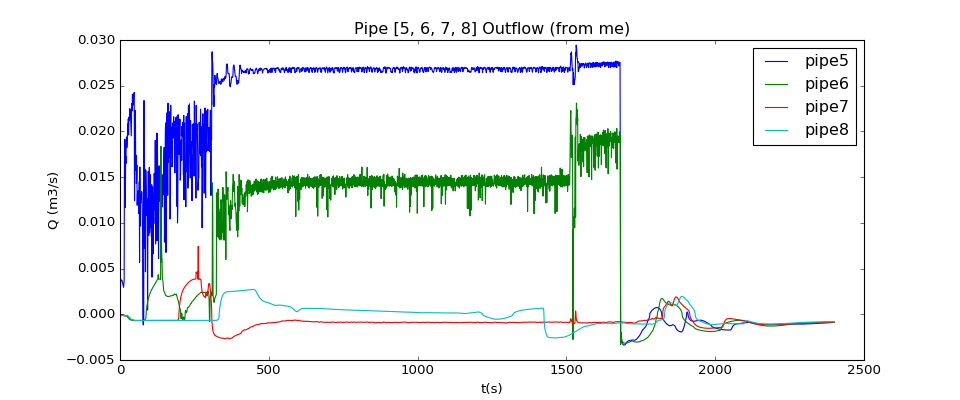

<IPython.core.display.Javascript object>


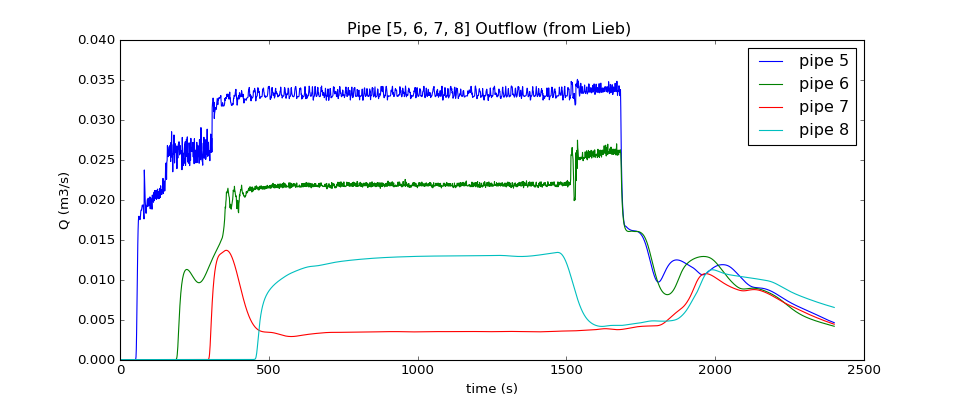

In [16]:
# average_all [pipe][time_step]
# Using the average gradient along the pipe to get 
U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

g = 9.81
pipe_interest = range(5,9)
plt.figure(figsize= (12,5)) 
for pipe in pipe_interest:
    mean_gradient = average_all[pipe]
    Q_pipefixed = []
    for time in xrange(len(mean_gradient)):
        #using the equation of pressurized short pipe, assume that the pipe is full
        # Q = miu*A*sqrt(2*g*(H2-H1))
        lambuda = 0.037
        miu = 1/sqrt(1+lambuda*n1.Ls[pipe]/n1.Ds[pipe]) # no obvious local loss, only frictional loss
        delta_head = mean_gradient[time]*(n1.Ns[pipe]-3)/n1.Ns[pipe]*n1.Ls[pipe]
        A = n1.Ds[pipe]**2/4*pi
        if delta_head<0:
            Q=-miu*A*sqrt(abs(2*g*delta_head))
        else:
            Q = miu*A*sqrt(abs(2*g*delta_head))
        Q_pipefixed.append(Q) 
    plt.plot(t_dev,Q_pipefixed,label='pipe%d'%pipe) 
    legend()
    plt.xlabel('t(s)')
    plt.ylabel('Q (m3/s)')
    plt.title('Pipe %s Outflow (from me)'%str(pipe_interest))
#savefig('/home/xin/pipes/examples/output_data/EpipeFig/Outflow/Pipe %s Outflow (from me).png'%str(pipe_interest), bbox_inches='tight')

    
# Compare with Lieb's results from equation
Q=[]
for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_end=[]
    for m in xrange(0,n1.M,Mi_draw) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        Q_end.append(qh[idx_t(1,N-1,m,N)])     # QN
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mi_draw+1)
plt.figure(figsize= (12,5))             # plot on different figures
for i in range(len(pipe_interest)):        
        plot(xt,Q[i][0], lw = 1,label = 'pipe %d'%(pipe_interest[i]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        legend()
        xlabel('time (s)')
        ylabel('Q (m3/s)')
        title('Pipe %s Outflow (from Lieb) '%str(pipe_interest))
#savefig('/home/xin/pipes/examples/output_data/EpipeFig/Outflow/Pipe %s Outflow (from Libe).png'%str(pipe_interest), bbox_inches='tight')


# 4.1 Inflow and Outflow for All Pipes in Model (Using ΣQ*dt)

In [ ]:
# Display the inflow and outflow for each pipe (m^3)  (ALl PIPES IN MODEL)


# Get Q of two ends of each pipe
Q = []
Mstep=1
#pipe_interest=[0]
pipe_interest=range(0,9)   
'''Here I redefine the pipe_interest vector'''

for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_start=[]
    Q_end=[]
    for m in xrange(0,n1.M,Mstep) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        Q_start.append(qh[idx_t(1,1,m,N)])   # Q1
        Q_end.append(qh[idx_t(1,N-1,m,N)])     # QN
    Q_pipefix.append(Q_start)
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)
endorstart=['start','end']
for i in range(len(pipe_interest)):
    plt.figure(figsize= (10,4))                # same pipe on same figure
    for j in range(0,2):  
        #figsize = (15,5)                        # plot on same figure           
        #plt.figure(figsize= (15,5))             # plot on different figures
        plot(xt,Q[i][j], lw = 1,label = 'pipe %d, %s'%(pipe_interest[i],endorstart[j]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        legend()
        xlabel('time (s)')
        ylabel('flux (m^3/s)')
        title('Flux in pipe %d'%pipe_interest[i])

# calculate inflow and outflow, i means pipe number, j means start or end, time means time in vector  
delta_t=Mstep*dt
Q_total=[]
for i in range(len(pipe_interest)):
    Q_total_pipefix=[]
    for j in range(0,2):
        Q_sum=0
        for time in range(len(Q[i][j])):
            Q_sum += Q[i][j][time]*delta_t
        Q_total_pipefix.append(Q_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 (%s node)'%(pipe_interest[i],n1.T,Q_sum,endorstart[j])
    V_dif = Q_total_pipefix[0]- Q_total_pipefix[1]
    print V_dif
    Q_total.append(Q_total_pipefix)


   

# 4.2 Calculate total outflow using Q above

In [ ]:
# Using the flux above to calculate total outflow
outflow_pipe = [4,5,6,7,8]
sum_outflow = 0
for i in outflow_pipe:
    sum_outflow += Q_total[i][1]
print 'The total outflow is %.1f m^3, the total volume in pipe is %.1f m^3'%(sum_outflow,V1)
print 'Total Inflow - Total Outflow - Water in pipes = %.1f m^3'%(Q_in1[0]*n1.T*0.7-sum_outflow-V1)

# 4.3 Mass Balance for Each Junction

In [ ]:
# Display mass balance for each junction

#******************************************************************************************
#The following three list must corresponds to each other 
JunNode=[1,2,3,4]
Pipejun_in=[[0],[1],[2],[3]]
Pipejun_out=[[1,5],[2,6],[3,7],[4,8]]
#******************************************************************************************


assert (len(Pipejun_in)==len(Pipejun_out)),"Different dimensions of Pipejun_in and Pipejun_out!"

# Create x axis
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)

# Q[i][j][k]   i means pipe number, j means start or end, k means time in vector 
for i in xrange(len(Pipejun_in)):
    Qjun_dif = []
    for k in xrange(len(Q[0][1])):
        Qinflow = 0
        Qoutflow = 0
        for j1 in Pipejun_in[i]:
            Qinflow += Q[j1][1][k]
        for j2 in Pipejun_out[i]:
            Qoutflow += Q[j2][0][k]
        Qjun_dif.append(Qinflow-Qoutflow)
    plt.figure(figsize= (10,4)) 
    plot(xt,Qjun_dif)   
    xlabel('t(s)')
    ylabel('Flux difference (m^3/s)')
    title('Junction %d Mass Conservation (Qin-Qout)'%JunNode[i])


# 5.1 Water Volume (using ΣAw*dx) in Pipes Change with Time

In [ ]:
#*****************************************************************************
pipe_interest1=range(0,9)
#*****************************************************************************

# Get A of two ends of each pipe
A = [] # all time, all pipes, all A values in grids
M_total=n1.M+1
Mi_draw=100

for m in xrange(0,M_total,Mi_draw) :
    A_tfixed=[] # certain time, all pipes, all A values in grids
    for i in xrange(len(pipe_interest1)):
        j = pipe_interest1[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Atemp=[]  #certain time, certain pipe, all A values in grids
        for k in xrange(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]      
            Atemp.append(Ak)
        A_tfixed.append(Atemp)     
    A.append(A_tfixed)
        
#calculate total volumn, i means time, j means pipe number, distance means value of grids  
V_total=[]
for i in xrange(0,M_total,Mi_draw):
    V_total_tfix=[]
    for j in xrange(len(pipe_interest1)):
        V_sum=0
        pipe_number=pipe_interest1[j]
        delta_x=n1.Ls[pipe_number]/n1.Ns[pipe_number]
        for distance in xrange(len(A[int(i/Mi_draw)][j])):
            V_sum += A[int(i/Mi_draw)][j][distance]*delta_x
        V_total_tfix.append(V_sum)
        #print 'Pipe %d during %d s have total flow: %.3f m^3 '%(pipe_number,i*dt,V_sum)
    #print 'The total volumn at t=%d s are                      %.3f m^3'%(i*dt,sum(V_total_tfix))
    V_total.append(V_total_tfix)

xt1 = np.linspace(0, M_total*dt, M_total/Mi_draw)
plt.figure(figsize= (11,5))
title('Water Volume in Pipe ~ time')
xlabel('t(s)')
ylabel('V(m^3)')
for j in xrange(len(pipe_interest1)):
    pipe_number=pipe_interest1[j]
    V_total_pipefix=[]
    for i in xrange(1,M_total,Mi_draw):
        V_total_pipefix.append(V_total[int(i/Mi_draw)][j])
    plot(xt1,V_total_pipefix,label = 'pipe %d'%pipe_number)
    legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)


# 5.2 Show Pipe End Details 
## Input: pipe, time
## Output: flux, water cross-section area, velocity

In [ ]:
# illustrate why v is not zero even when empty
def ShowQAofPipeEnd(pipe_detect,time_detect,total_time,total_timestep):
    timestep=int(time_detect/total_time*total_timestep)
    Q=n1.qhist(pipe_detect)[idx_t(1,n1.Ns[pipe_detect],timestep,n1.Ns[pipe_detect])]   #Q at middle of time, end of pipe 4
    A=n1.qhist(pipe_detect)[idx_t(0,n1.Ns[pipe_detect],timestep,n1.Ns[pipe_detect])]   #A at middle of time, end of pipe 4
    print '**************************************************************************************'
    print "At %ds, at the end of pipe %d:"%(time_detect,pipe_detect)
    print "  The Flux  is  %.8f m^3/s" %Q
    print "  The water cross area is %.8f m^2 "%A
    print '  The velocity is %.8f m/s'%(Q/A)
    print "**************************************************************************************"
    
#******************************************************************************
ShowQAofPipeEnd(4,1800,n1.T,n1.M)
#******************************************************************************

# 5.3 Pressure Head of Certain Pipe, Certain Location
## Input: pipe, location
## Output: pressure head (nearest grid) ~ time

In [ ]:
# Plot the Pressure head at the end of all outflow pipes
#********************************************************************
pipe_interest=[0,1]
pipe_location=[99,80]               # unit:m
#********************************************************************

t = linspace(0,n1.T,n1.M+1)
plt.figure(figsize= (11,5))                  # same figure
for i in xrange(len(pipe_interest)):
    pipe_number=pipe_interest[i]
    dx=n1.Ls[pipe_number]/n1.Ns[pipe_number]
    pipe_grid = int(pipe_location[i]/dx)
    P = n1.pressureTimeSeries(pipe_number,pipe_grid)
    #plt.figure(figsize= (10,4))                  # different figure
    plt.plot(t,P,label = "pipe %d, %.1f m" %(pipe_number,pipe_grid*dx))
    xlabel('t(s)')
    ylabel('H(m)')
    legend(bbox_to_anchor=(0.85, 1.13), loc=2, borderaxespad=0.)
    title('Pressure Head at pipe %d, %.2f m '%(pipe_number,pipe_grid*dx))

# Show Layout of Pipe Network

In [ ]:
'''
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np= shape(conns) [0]
plotNetworkLayout (xs, ys, conns, ls, Np) 
n1.showLayout() 
'''

In [ ]:
"""
# Velocity of pipe_interest pipes, static image
U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

Mi_draw=10000
for m in range(0,M_total,Mi_draw) :
    U_interest_tfixed=[] 
    for i in range(len(pipe_interest)):
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Utemp=[]
        for k in range(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]
            AN=qh[idx_t(0,N,m,N)]
            Qk=qh[idx_t(1,k,m,N)]
            # when Q is actually very samll and its value is due to numerical oscillation, set it as 0
            if abs(Ak-AN)<0.1*A_pipe[i] and AN<0.1*A_pipe[i]:  
                Qk=0   
            vk = Qk/Ak                 
            Utemp.append(vk)
        U_interest_tfixed.append(Utemp)
    U_interest.append(U_interest_tfixed)
    U_interest_combine = np.concatenate(U_interest[int(m/Mi_draw)],axis =0)
    plt.figure(figsize= (10,4))    #plot on different figures
    #figsize= (15,5)                 #plot on the same figure
    plt.plot(x_interest_combine,U_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    '''
    #plt.figure(figsize= (15,5))
    for i in range(len(pipe_interest)):
        figsize(15,5)
        plot(x_interest[i],U_interest[int(m/Mi_draw)][i], lw = 1,  label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
        # m is time step, and should divide m/Mi_draw to get what we need
        #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    '''
    xlabel('x (m)')        
    ylabel('Velocity (m/s)')
    xlim(0,x_interest[-1][-1]+1)
    Umax=1.1*max(U_interest_combine)
    #ylim(-0.1,2.5)
    ylim(-0.1,1.2*Umax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Velocity along pipe %s'%str(pipe_interest))
    # print U_interest[5][1]   # first index is #*Mi timestep, second index is pipe # in pipe_interest list
"""

# Pressure Head at End of All Outflow Pipes

In [ ]:
# Plot the Pressure head at the end of all outflow pipes

t = linspace(0,n1.T,n1.M+1)
for i in xrange(1,len(jt)):
    if jt[i]==1:
        pipe_number=i-1
        Pend = n1.pressureTimeSeries(int(pipe_number),n1.Ns[pipe_number])
        #Pstart=n1.pressureTimeSeries(int(pipe_number),1)
        #figsize=(15,5)
        #plt.figure(figsize= (10,4))
        #plt.plot(t,Pstart,label = "start of pipe %d" %(i-1))
        #legend()
        plt.figure(figsize= (10,4))                  # so that every time it can create a new figure
        plt.plot(t,Pend,label = "End of pipe %d" %(i-1))
        xlabel('t(s)')
        ylabel('H(m)')
        legend()
        title('Pressure Head at end of pipe %d'%pipe_number)